In [2]:

from matplotlib import pyplot as plt
import seaborn as sns

import pickle
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from scipy.sparse import hstack
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

###########
# FUNCTIONS
###########

def get_auc_lr_valid(X, y, C=1.0, seed=17, ratio = 0.9):
    # Split the data into the training and validation sets
    idx = int(round(X.shape[0] * ratio))
    # Classifier training
    lr = LogisticRegression(C=C, random_state=seed, solver='lbfgs', max_iter=500).fit(X[:idx, :], y[:idx])
    # Prediction for validation set
    y_pred = lr.predict_proba(X[idx:, :])[:, 1]
    # Calculate the quality
    score = roc_auc_score(y[idx:], y_pred)

    return score



times = ['time%s' % i for i in range(1, 11)]

train_df = pd.read_csv('train_sessions.csv',
                       index_col='session_id', parse_dates=times)
test_df = pd.read_csv('test_sessions.csv',
                      index_col='session_id', parse_dates=times)

# Sort the data by time
#train_df = train_df.sort_values(by='time1')

sites = ['site%s' % i for i in range(1, 11)]
train_df[sites] = train_df[sites].fillna(0).astype('int')
test_df[sites] = test_df[sites].fillna(0).astype('int')

# Load websites dictionary
with open(r"site_dic.pkl", "rb") as input_file:
    site_dict = pickle.load(input_file)

# Create dataframe for the dictionary
sites_dict = pd.DataFrame(list(site_dict.keys()), index=list(site_dict.values()), columns=['site'])
print(u'Websites total:', sites_dict.shape[0])
#sites_dict.head()

# Our target variable
y_train = train_df['target'].values

# United dataframe of the initial data
full_df = pd.concat([train_df.drop('target', axis=1), test_df])

# Index to split the training and test data sets
idx_split = train_df.shape[0]

# small
train_df[sites].fillna(0).to_csv('train_sessions_text.txt',
                                 sep=' ', index=None, header=None)
test_df[sites].fillna(0).to_csv('test_sessions_text.txt',
                                sep=' ', index=None, header=None)


cv = CountVectorizer(ngram_range=(1, 3), max_features=50000)
with open('train_sessions_text.txt') as inp_train_file:
    X_train = cv.fit_transform(inp_train_file)
with open('test_sessions_text.txt') as inp_test_file:
    X_test = cv.transform(inp_test_file)
print(X_train.shape, X_test.shape)



def write_to_submission_file(predicted_labels, out_file, target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)
# Calculate metric on the validation set
print(get_auc_lr_valid(X_train, y_train))

train_df_newfeatures = pd.DataFrame(index=train_df.index)
test_df_newfeatures = pd.DataFrame(index=test_df.index)

train_df_newfeatures['year'] = train_df['time1'].apply(lambda ts : ts.year * 100 + ts.month)
test_df_newfeatures['year'] = test_df['time1'].apply(lambda ts : ts.year * 100 + ts.month)

train_df_newfeatures['hour'] = train_df['time1'].apply(lambda ts : ts.hour)
test_df_newfeatures['hour'] = test_df['time1'].apply(lambda ts : ts.hour)

# is time between 5 and 13
train_df_newfeatures['morning'] = ((train_df_newfeatures['hour'] > 5) & (train_df_newfeatures['hour'] < 13)) * 1 - 0.5
test_df_newfeatures['morning'] = ((test_df_newfeatures['hour'] > 5) & (train_df_newfeatures['hour'] < 13)) * 1- 0.5

train_df_newfeatures['evening'] = ((train_df_newfeatures['hour'] > 17) & (train_df_newfeatures['hour'] < 23)) * 1 - 0.5
test_df_newfeatures['evening'] = ((test_df_newfeatures['hour'] > 17) & (train_df_newfeatures['hour'] < 23)) * 1- 0.5

times = ['time%s' % i for i in range(1, 11)]
train_df_newfeatures['session_lenght'] = (train_df[times].max(axis = 1) - train_df[times].min(axis = 1)).apply(lambda ts: ts.seconds)
test_df_newfeatures['session_lenght'] = (test_df[times].max(axis = 1) - test_df[times].min(axis = 1)).apply(lambda ts: ts.seconds)

scaler = StandardScaler()
scaler.fit(test_df_newfeatures['year'].values.reshape(-1, 1))
train_df_newfeatures['year_scaled'] = scaler.fit_transform(train_df_newfeatures['year'].values.reshape(-1,1))
test_df_newfeatures['year_scaled'] = scaler.transform(test_df_newfeatures['year'].values.reshape(-1,1))

scaler.fit(test_df_newfeatures['hour'].values.reshape(-1, 1))
train_df_newfeatures['hour_scaled'] = scaler.fit_transform(train_df_newfeatures['hour'].values.reshape(-1,1))
test_df_newfeatures['hour_scaled'] = scaler.transform(test_df_newfeatures['hour'].values.reshape(-1,1))

scaler.fit(test_df_newfeatures['session_lenght'].values.reshape(-1, 1))
train_df_newfeatures['session_lenght_scaled'] = scaler.fit_transform(train_df_newfeatures['session_lenght'].values.reshape(-1,1))
test_df_newfeatures['session_lenght_scaled'] = scaler.transform(test_df_newfeatures['session_lenght'].values.reshape(-1,1))

X_train_new = csr_matrix(hstack([X_train, train_df_newfeatures[['year_scaled', 'hour_scaled', 'morning', 'evening', 'session_lenght_scaled']]]))
X_test_new = csr_matrix(hstack([X_test, test_df_newfeatures[['year_scaled', 'hour_scaled', 'morning', 'evening','session_lenght_scaled']]]))

Websites total: 48371
(253561, 50000) (82797, 50000)
0.9594476056982224


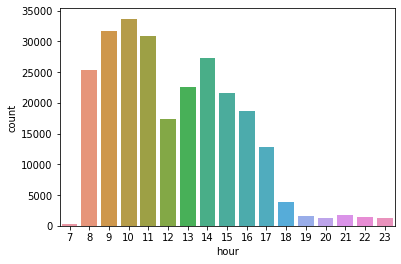

In [11]:
sns.countplot(data = train_df_newfeatures[], x = 'hour')